In [29]:
import logging
import sys
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt

from simsopt.field.boozermagneticfield import (
        BoozerRadialInterpolant,
        InterpolatedBoozerField,
        ShearAlfvenHarmonic,
        ShearAlfvenWavesSuperposition
        )
from simsopt._core.util import parallel_loop_bounds
from simsopt.field.tracing import (
        MaxToroidalFluxStoppingCriterion,
        MinToroidalFluxStoppingCriterion,
        IterationStoppingCriterion,
        trace_particles_boozer_perturbed
)
from simsopt.util.constants import (
        ALPHA_PARTICLE_MASS as MASS,
        ALPHA_PARTICLE_CHARGE as CHARGE,
        FUSION_ALPHA_PARTICLE_ENERGY as ENERGY
)
from simsopt.util.constants import ALPHA_PARTICLE_MASS, ALPHA_PARTICLE_CHARGE, FUSION_ALPHA_PARTICLE_ENERGY
from booz_xform import Booz_xform
from stellgap import AE3DEigenvector, saw_from_ae3d
import stellgap as sg
from scipy import integrate
from matplotlib.cm import ScalarMappable
import simsoptpp as sopp
import matplotlib as mpl
helicity = -1

In [30]:
print(saw_m)
print(saw_n)
print(saw_phihats)
print(saw_nharmonics)
print(s)

17
-17
[   1.28033577    2.00807429    2.68778328    3.33284293    3.995455
    4.86106818    6.52932961   10.75676257   22.16026106   51.44654731
  119.84920322  260.98822943  508.59941383  846.82259508 1019.94555822
  899.74217026  743.66786875  586.04378229  443.66694617  324.10847526
  229.1481124   157.13278238  104.68267601   67.85309227   42.84662128
   26.38334732   15.83555236    9.21817371    5.10437211    2.5133545 ]
1
[0.05       0.08103448 0.11206897 0.14310345 0.17413793 0.20517241
 0.2362069  0.26724138 0.29827586 0.32931034 0.36034483 0.39137931
 0.42241379 0.45344828 0.48448276 0.51551724 0.54655172 0.57758621
 0.60862069 0.63965517 0.67068966 0.70172414 0.73275862 0.7637931
 0.79482759 0.82586207 0.85689655 0.88793103 0.91896552 0.95      ]


In [40]:
print(saw_m)
print(saw_n)
print(saw_phihats)
print(saw_nharmonics)
print(s)

17
-17
[   1.28033577    2.00807429    2.68778328    3.33284293    3.995455
    4.86106818    6.52932961   10.75676257   22.16026106   51.44654731
  119.84920322  260.98822943  508.59941383  846.82259508 1019.94555822
  899.74217026  743.66786875  586.04378229  443.66694617  324.10847526
  229.1481124   157.13278238  104.68267601   67.85309227   42.84662128
   26.38334732   15.83555236    9.21817371    5.10437211    2.5133545 ]
1
[0.05       0.08103448 0.11206897 0.14310345 0.17413793 0.20517241
 0.2362069  0.26724138 0.29827586 0.32931034 0.36034483 0.39137931
 0.42241379 0.45344828 0.48448276 0.51551724 0.54655172 0.57758621
 0.60862069 0.63965517 0.67068966 0.70172414 0.73275862 0.7637931
 0.79482759 0.82586207 0.85689655 0.88793103 0.91896552 0.95      ]


In [32]:
import simsoptpp as sopp

bump_multi = 0.1

filename = 'boozmn_precise_QH.nc'
ic_folder = 'initial_conditions'

saw_filename = 'mode/scaled_mode_32.935kHz.npy'
saw_data = np.load(saw_filename, allow_pickle=True)
saw_data = saw_data[()]
saw_omega = 32935.0
print("omega=", saw_omega)
s = np.linspace(0.05,0.95,30)
saw_srange = (s[0], s[-1], len(s))
saw_m = 17
saw_n = -17

def sah_profile(s):
    """SAH amplitude profile"""
    s = np.asarray(s)
    sc, lw, rw, h, p, off = 0.475541, 0.068345, 0.484077, 4.124030, 1.442968, 0.026951
    result = np.zeros_like(s, dtype=float)
    result = np.where(s <= sc, 
                      h * np.exp(-((sc - s)/lw)**p), 
                      h * np.exp(-((s - sc)/rw)**p))
    amplitude = 1000.0
    return (amplitude*(result + off) * s * (1-s))

saw_phihats = sah_profile(s)
saw_nharmonics = 1

logging.basicConfig()
logger = logging.getLogger('simsopt.field.tracing')

t1 = time.time()
equil = Booz_xform()
equil.verbose = 0
equil.read_boozmn(filename)
nfp = equil.nfp

s_init = np.loadtxt(f's_perturbed_init_poinc.txt', ndmin=1)
theta_init = np.loadtxt(f'chis_perturbed_init_poinc.txt', ndmin=1)
zeta_init = np.loadtxt(f'chis_perturbed_init_poinc.txt', ndmin=1)
vpar_init = np.loadtxt(f'vpar_perturbed_init_poinc.txt', ndmin=1)
# s_init = s_init[:1]
# theta_init = theta_init[:1]
# zeta_init = zeta_init[:1]
# vpar_init = vpar_init[:1]
points = np.zeros((s_init.size, 3))
points[:, 0] = s_init
points[:, 1] = theta_init
points[:, 2] = zeta_init
points = np.ascontiguousarray(points)
vpar_init = np.ascontiguousarray(vpar_init)


omega= 32935.0


/tmp/ipykernel_485847/3348888625.py:24: RuntimeWarning: invalid value encountered in power
  h * np.exp(-((sc - s)/lw)**p),
/tmp/ipykernel_485847/3348888625.py:25: RuntimeWarning: invalid value encountered in power
  h * np.exp(-((s - sc)/rw)**p))


In [34]:
bri = BoozerRadialInterpolant(
    equil=equil,
    order=3,
    no_K=True,
    N=nfp*helicity
)

degree = 3
srange = (0, 1, 48)
thetarange = (0, np.pi, 48)
zetarange = (0, 2*np.pi/nfp, 48)

field = InterpolatedBoozerField(
    bri,
    degree=3,
    srange=(0, 1, 48),
    thetarange=(0, np.pi, 48),
    zetarange=(0, 2*np.pi/nfp, 48),
    extrapolate=True,
    nfp=nfp,
    stellsym=True,
    initialize=['modB','modB_derivs']
)

# Evaluate error in interpolation
print('Error in |B| interpolation', 
    field.estimate_error_modB(1000),
    flush=True)

VELOCITY = np.sqrt(2*ENERGY/MASS)

# set up GPU interpolation grid
def gen_bfield_info(field, srange, trange, zrange):

	s_grid = np.linspace(srange[0], srange[1], srange[2])
	theta_grid = np.linspace(trange[0], trange[1], trange[2])
	zeta_grid = np.linspace(zrange[0], zrange[1], zrange[2])

	quad_pts = np.empty((srange[2]*trange[2]*zrange[2], 3))
	for i in range(srange[2]):
		for j in range(trange[2]):
			for k in range(zrange[2]):
				quad_pts[trange[2]*zrange[2]*i + zrange[2]*j + k, :] = [s_grid[i], theta_grid[j], zeta_grid[k]]


	field.set_points(quad_pts)
	G = field.G()
	iota = field.iota()
	diotads = field.diotads()
	I = field.I()
	modB = field.modB()
	J = (G + iota*I)/(modB**2)
	maxJ = np.max(J) # for rejection sampling

	psi0 = field.psi0

	# Build interpolation data
	modB_derivs = field.modB_derivs()

	dGds = field.dGds()
	dIds = field.dIds()

	quad_info = np.hstack((modB, modB_derivs, G, dGds, I, dIds, iota, diotads))
	quad_info = np.ascontiguousarray(quad_info)

	return quad_info, maxJ, psi0

# generate grid with 48 simsopt grid pts
n_grid_pts = 48
srange = (0, 1, 3*n_grid_pts+1)
trange = (0, np.pi, 3*n_grid_pts+1)
zrange = (0, 2*np.pi/nfp, 3*n_grid_pts+1)
quad_info, maxJ, psi0 = gen_bfield_info(field, srange, trange, zrange)

nparticles = len(points)

Error in |B| interpolation (7.491025623383795e-06, 1.6421068667553195e-05)


In [35]:
helicity = -1
zetas = [0]
Phim = 17
Phin = -17
omega = saw_omega
omegan = omega/(Phin - Phim*helicity*nfp)
omegas = [omegan]

In [36]:
first_two_points = points
first_two_vpar_init = vpar_init
nparticles = len(first_two_points)

In [41]:
last_time = sopp.poincare_plotting(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=first_two_points,
	m=MASS, 
	q=CHARGE, 
	vtang=first_two_vpar_init, 
    mus=np.zeros(nparticles),
	tmax=3e-2, 
	tol=1e-10, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6, MAX_PUNCTURES=10000, zetas=zetas, omegas=omegas)

In [42]:
last_time = np.reshape(last_time, (-1, 5))
last_time[:2] = last_time[:2] % (2 * np.pi)

p_hits = []
running = []

for i in range(0, len(last_time)):
    if (not np.any(last_time[i]) and len(running) > 0):
        # print(i)
        p_hits.append(running)
        running = []
        continue
    if np.any(last_time[i]):
        running.append(last_time[i])
        if i % 1000 == 9999:
            # print(i)
            p_hits.append(running)
            running = []
    # if i % 1000 == 999:
    #     print(i, "testing")

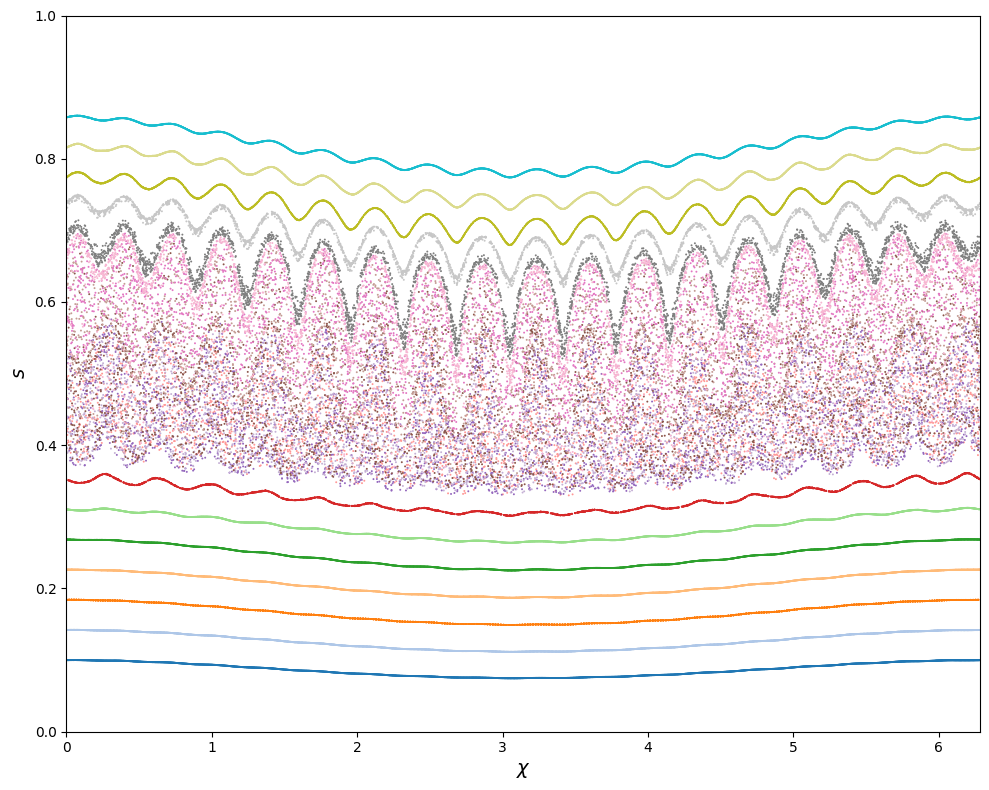

In [43]:
cmap = mpl.colormaps['tab20']

plt.figure(1, figsize=(10, 8))
plt.xlabel(r'$\chi$', fontsize=14)
plt.ylabel(r'$s$', fontsize=14)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 1])
counter = 0
for p in p_hits:
    hits = np.asarray(p)
    s_hits = hits[:, 0]
    helicity = -1
    chi_hits = (hits[:, 1] - nfp * helicity * hits[:, 2]) % (2 * np.pi)
    theta_hits = (hits[:, 1] + 2*np.pi) % (2 * np.pi) - np.pi
    plt.scatter(chi_hits, s_hits, s=2, edgecolors='none', marker='o', color=cmap(counter))
    counter += 1

plt.tight_layout()
plt.savefig('gpu_map_poincare_colored.pdf', dpi=300)


In [ ]:
last_time = np.reshape(last_time, (-1, 5))
last_time[:2] = last_time[:2] % (2 * np.pi)
hits = (last_time[~(last_time == 0).all(1)])
# print(hits)
print(len(hits))
print((hits[:, 2] % (2 * np.pi)) % (2 * np.pi))

In [ ]:
plt.figure(1, figsize=(10, 8))
plt.xlabel(r'$\chi$', fontsize=14)
plt.ylabel(r'$s$', fontsize=14)
plt.xlim([0, 2 * np.pi])
plt.ylim([0, 1])
s_hits = hits[:, 0]
helicity = -1
chi_hits = (hits[:, 1] - nfp * helicity * hits[:, 2]) % (2 * np.pi)
theta_hits = (hits[:, 1] + 2*np.pi) % (2 * np.pi) - np.pi
plt.scatter(chi_hits, s_hits, s=2, edgecolors='none', marker='o')

In [ ]:
point_hits = np.zeros((len(hits), 4))
point_hits[:, 0] = hits[:, 0]
point_hits[:, 1] = hits[:, 1]
point_hits[:, 2] = hits[:, 2]
point_hits[:, 3] = hits[:, 4]

vpar_hits = hits[:, 3]


print(saw_Pzeta_Eprime_calc(saw, point_hits, vpar_hits))

In [ ]:
times = hits[:, 4]
times = times[np.where(times < 1e-3)]
print(len(times))

In [ ]:
last_time = sopp.poincare_plotting(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=first_two_points,
	m=MASS, 
	q=CHARGE, 
	vtang=first_two_vpar_init, 
    mus=np.zeros(nparticles),
	tmax=1e-3, 
	tol=1e-8, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6, MAX_PUNCTURES=1000, zetas=zetas, omegas=omegas)

In [ ]:
mus=np.ascontiguousarray(np.zeros(len(vpar_init)))

In [ ]:
last_time = sopp.gpu_tracing_saw(
	quad_pts=quad_info, 
	srange=srange,
	trange=trange,
	zrange=zrange, 
	stz_init=points,
	m=MASS, 
	q=CHARGE, 
	vtang=vpar_init,
    mus=mus,
	tmax=1e-3,
	tol=1e-9, 
	psi0=psi0, 
	nparticles=nparticles,
	saw_srange=saw_srange,
	saw_m=saw_m,
	saw_n=saw_n,
	saw_phihats=saw_phihats,
	saw_omega=saw_omega,
	saw_nharmonics=saw_nharmonics, dt_save=1e-6)

In [ ]:
last_time = np.asanyarray(last_time, dtype=float)

def split_nonzero_runs(x):
    # boolean mask of non‑zeros
    mask = x != 0
    if not mask.any():
        return []

    # compute where mask changes: +1 marks a start, -1 marks an end
    diff = np.diff(mask.astype(int))
    starts = np.where(diff ==  1)[0] + 1
    ends   = np.where(diff == -1)[0]

    # if the very first element is non‑zero, that's a start
    if mask[0]:
        starts = np.r_[0, starts]
    # if the very last element is non‑zero, that's an end
    if mask[-1]:
        ends = np.r_[ends, mask.size - 1]

    # now slice out each run [s:e]
    return [ x[s:e+1] for s, e in zip(starts, ends) ]


# example
gc_tys = split_nonzero_runs(last_time)



In [ ]:
for i in range(len(gc_tys)):
    gc_tys[i] = np.reshape(gc_tys[i], (-1, 5))

In [ ]:
def saw_Pzeta_Eprime_calc(saw,points,vpar):
    saw.set_points(points)
    modB = saw.B0.modB()[:,0]
    G = saw.B0.G()[:,0]
    # enforce vaccuum condition I = 0
    I = 0
    psi = saw.B0.psi0 * points[:, 0]
    psip = saw.B0.psip()[:,0]
    alpha = saw.alpha()[:,0]
    phi = saw.Phi()[:,0]

    Energy = 0.5*MASS*vpar**2 + MU * modB + CHARGE*phi
    # print(vpar, modB, CHARGE*phi)

    Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    # Pzeta = (G + helicity * nfp * I) * ((MASS * vpar)/modB + alpha * CHARGE) + CHARGE * (helicity * nfp * psi - psip)
    

    Eff = (Phin-helicity*nfp*Phim)*Energy-omega*Pzeta
    return Energy,Pzeta,Eff

In [ ]:
gpu_unperturbed_traj = (gc_tys[0])
unperturbed_gpu_points = np.zeros(np.shape(gpu_unperturbed_traj[:, :4]))
unperturbed_gpu_points[:, 0] = gpu_unperturbed_traj[:, 0]
unperturbed_gpu_points[:, 1] = gpu_unperturbed_traj[:, 1]
unperturbed_gpu_points[:, 2] = gpu_unperturbed_traj[:, 2]
unperturbed_gpu_points[:, 3] = gpu_unperturbed_traj[:, 4]
unperturbed_gpu_vpar = gpu_unperturbed_traj[:, 3]


unperturbed_gpu_E, unperturbed_gpu_Pz, unperturbed_gpu_Ep = saw_Pzeta_Eprime_calc(saw, unperturbed_gpu_points, unperturbed_gpu_vpar)

print("GPU: Unperturbed Energy conserved to ", -np.log10(np.max(np.abs((unperturbed_gpu_E - unperturbed_gpu_E[0])/unperturbed_gpu_E[0]))), " digits")
print("GPU: Unperturbed Pzeta conserved to ", -np.log10(np.max(np.abs((unperturbed_gpu_Pz - unperturbed_gpu_Pz[0])/unperturbed_gpu_Pz[0]))), " digits")
print("GPU: Unperturbed Pzeta conserved to ", -np.log10(np.max(np.abs((unperturbed_gpu_Ep - unperturbed_gpu_Ep[0])/unperturbed_gpu_Ep[0]))), " digits")




In [ ]:
plt.plot(unperturbed_gpu_Ep)